<a href="https://colab.research.google.com/github/dahouda2pro/XAI-Image-Class-ViT/blob/main/XAI_Image_Class_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install GPy, GPyOpt
#!pip install GPy
#!pip install GPyOpt
!pip install tensorflow-addons

In [3]:
# Install GPy, GPyOpt
##!pip install GPy==1.9.8
#!pip install GPyOpt==1.2.1
#!pip install tensorflow-addons

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as K
import tensorflow_addons as tfa
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import GPy
#import GPyOpt
#from GPyOpt.methods import BayesianOptimization

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
!python3 --version
#Python 3.6.9
print(tf.__version__)
#2.3.0
#print(K.__version__)
#2.4.0
print(np.__version__)


Python 3.10.12
2.14.0
1.23.5


In [5]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    #X = K.applications.NASNetLarge.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [6]:

# load the Cifar10 dataset, 50,000 training images and 10,000 test images (here used as validation data)
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)



num_classes = 10
input_shape = (32, 32, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


Configure the hyperparameters

In [7]:
class Config:
    input_size = 32
    input_shape = [input_size, input_size, 3]
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_classes = 10
    num_epochs = 100
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

In [8]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

In [9]:
(train_data, train_labels),(test_data, test_labels)  = keras.datasets.cifar10.load_data()
(train_data.shape, train_labels.shape),(test_data.shape, test_labels.shape)

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

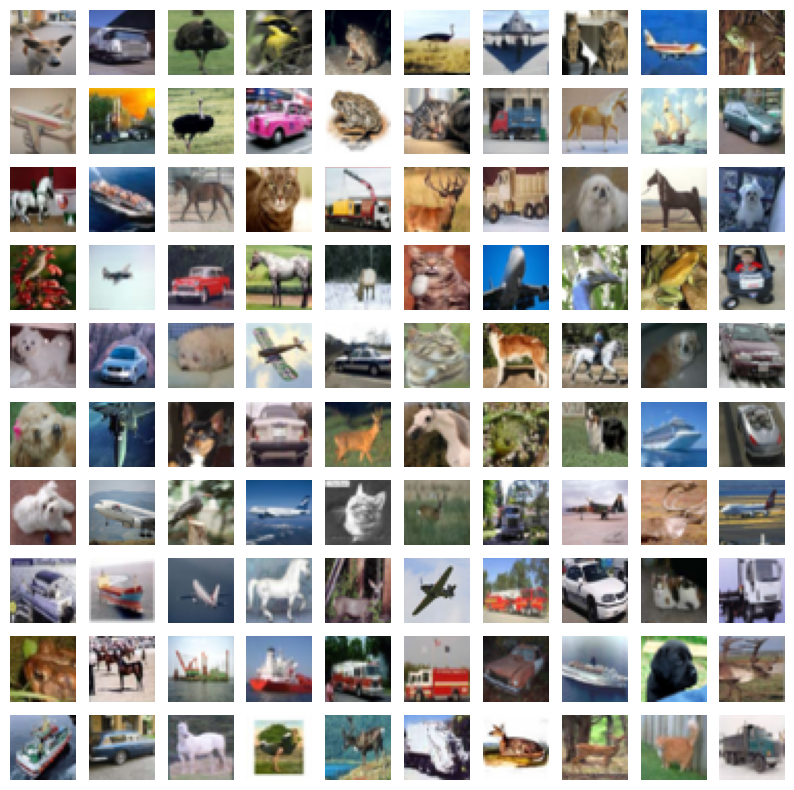

In [10]:
indices = np.random.choice(train_data.shape[0], 100)
sample_images(train_data[indices], 10, 10)

 Use data augmentation

In [11]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [12]:
augmentation_layer.layers[0].adapt(train_data)

 Implement multilayer perceptron (MLP)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
# Implement patch creation as a layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(32, 32, 3)
(1, 72, 72, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches Sahpe: (1, 144, 108)
Patches per image: 144
Elements per patch: 108


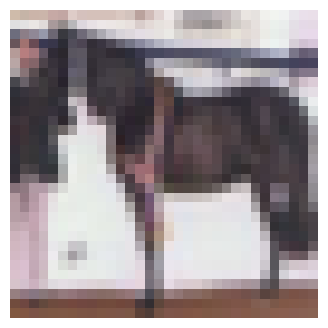

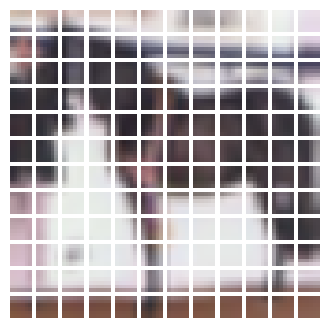

In [15]:

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_data[np.random.choice(range(train_data.shape[0]))]
print(image.shape)
plt.imshow(np.squeeze(image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches Sahpe: {patches.shape}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [16]:
"""
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

"""
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model

In [17]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads,
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = layers.Add()([attention_output, encoder_patches])

        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

        # Skip Connnection 2
        encoder_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Compile, train, and evaluate the model

In [18]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 72, 72, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches[0][0]']             
 r)                                                                                           

In [19]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [20]:
history = vit_classifier.fit(train_data, train_labels, verbose=1, epochs=50, batch_size=Config.batch_size, validation_data=(test_data, test_labels), callbacks=[checkpoint])

Epoch 1/50
196/196 [==============================] - 89s 372ms/step - loss: 2.0110 - accuracy: 0.3260 - val_loss: 1.5098 - val_accuracy: 0.4551
Epoch 2/50
196/196 [==============================] - 73s 373ms/step - loss: 1.5287 - accuracy: 0.4498 - val_loss: 1.2467 - val_accuracy: 0.5504
Epoch 3/50
196/196 [==============================] - 74s 380ms/step - loss: 1.3687 - accuracy: 0.5103 - val_loss: 1.1731 - val_accuracy: 0.5772
Epoch 4/50
196/196 [==============================] - 75s 381ms/step - loss: 1.2683 - accuracy: 0.5507 - val_loss: 1.0758 - val_accuracy: 0.6128
Epoch 5/50
196/196 [==============================] - 75s 384ms/step - loss: 1.1780 - accuracy: 0.5819 - val_loss: 0.9899 - val_accuracy: 0.6462
Epoch 6/50
196/196 [==============================] - 75s 383ms/step - loss: 1.1194 - accuracy: 0.6068 - val_loss: 0.9989 - val_accuracy: 0.6488
Epoch 7/50
196/196 [==============================] - 75s 382ms/step - loss: 1.0636 - accuracy: 0.6270 - val_loss: 0.9563 - val_ac

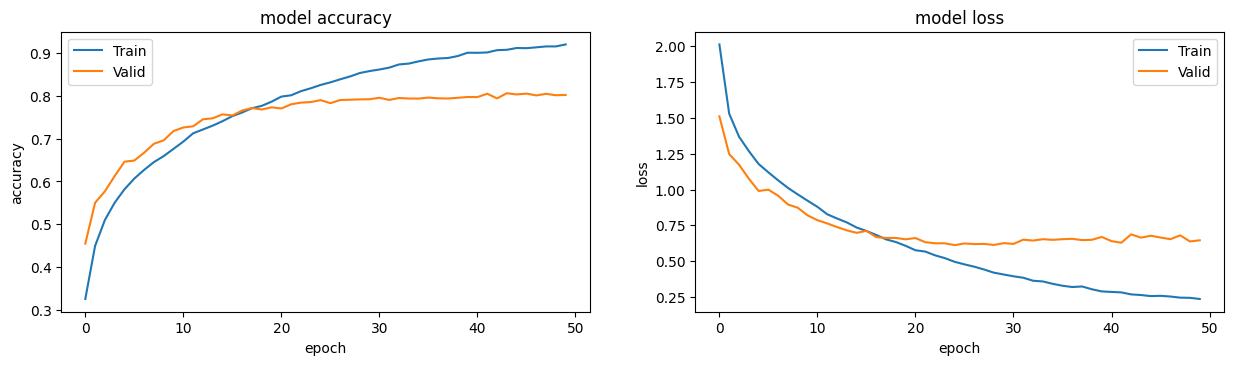

In [21]:
  # print(history_dict)
plot = 0
def plot_history(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plot = 0
    plt.savefig('Loss_Acc_'+str(plot)+'.pdf')
    plt.savefig('Loss_Acc_'+str(plot)+'.png')
    plot = plot + 1
    plt.show()

  # plot the model accuracy and loss results
plot_history(history)